In [1]:
import sys
# needed to import from sources
sys.path.append('..')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from data.sources import Sources
import numpy as np
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif
from sklearn.linear_model import LinearRegression,ElasticNet, Lasso,LogisticRegression
from scipy.optimize import minimize, LinearConstraint
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import joblib
import os

## Reading in Data and Preprocessing

In [3]:
# Helper function to convert graduation rates into numbers. This is necessary to convert rates that may be reported 
# as non-exact as the education data had to be privatized and not identifiable.
def rate_to_number(rate):
    chars = ["GE","LT","LE"]
    if "-" in rate:
        return int(rate.split("-")[0])
    elif any(i in rate for i in chars):
        for i in chars:
            rate = rate.replace(i, "")
        return int(rate)
    elif "PS" in rate:
        return None
    return int(rate)

# Helper function to help determine which columns are numeric as Pandas reads all entries from the query in as objects.
def represents_float(s):
    if s is None:
        return True
    try: 
        float(s)
    except ValueError:
        return False
    else:
        return True

# This gets the main dataset for a specific subset of years. It fetches the data from the MySQL database and does some
# parsing and data conversions to get the relevant columns and data for our model.
def get_main_data(years = ["2020"]):
    data = Sources("localhost", "aipi510_project", "root", "password") 

    query = f"""
    SELECT * FROM AIPI510_PROJECT.SSLE AS SSLE
    INNER JOIN AIPI510_PROJECT.SAIPE AS SAIPE
    ON SAIPE.`LEA ID` = SSLE.`LEA ID`
    
    INNER JOIN aipi510_project.graduation_rate_category AS GRAD_CAT
    ON GRAD_CAT.`NCESSCH` = SSLE.`NCES ID` AND GRAD_CAT.`CATEGORY` = 'ALL' AND GRAD_CAT.`year` = SAIPE.`year`
    
    INNER JOIN AIPI510_PROJECT.NCES_BY_YEAR AS NCES
    ON NCES.`school_id_nces_assigned` = SSLE.`NCES ID` AND NCES.`year` = SAIPE.`year`
    
    INNER JOIN AIPI510_PROJECT.title_i_max_funding AS funding
    on funding.`LEA ID` = SSLE.`LEA ID` AND funding.`year` = SAIPE.`year`
    
    INNER JOIN AIPI510_PROJECT.per_pupil_data as per_pupil_data
    on per_pupil_data.`site_name` = SSLE.`School name` AND per_pupil_data.`year` = SAIPE.`year`
    WHERE SSLE.`Title I eligibility`="Title I" AND SAIPE.`year` in ({','.join(years)}) AND per_pupil_data.`reporting_category` = "Per Pupil Expenses"

    """
    df = pd.read_sql_query(query, data.engine)
    
    # These are columns that we found were either not very predictive from the F-scores or not as relevant to our prediction.
    not_relevant_columns = "index ,NCES ID, State code, State abbreviation, LEA name, Grades offered lowest, Grades offered highest, District Name, State Code, SCHOOL_YEAR, STNAM, ST_LEAID, NCESSCH, ST_SCHID, SCHNAM, CATEGORY, DATE_CUR, school_name, state_name, Title I eligibility, School operational status,school_wide_title_i, title_i_eligible_school, title_i_school_status,grade_10_offered,updated_status,charter_school, school_type,school_system_code,school_system_name,site_code,reporting_category,reporting_subcategory,Personnel salaries at school level - total,Personnel salaries at school level - instructional staff only,Personnel salaries at school level - teachers only,Non-personnel expenditures at school level,Student enrollment,Per-pupil expenditure - total personnel salaries,Number free and reduced price lunch students"
    not_relevant_columns = not_relevant_columns.split(",")
    not_relevant_columns = [i.strip() for i in not_relevant_columns]

    # remove duplicate columns that arise from indexing / repeated data
    df = df.T.drop_duplicates().T
    df = df.loc[:,~df.columns.duplicated()].copy()
    df = df.drop(columns = not_relevant_columns)

    # replace "-" values with 0
    df = df.map(lambda x: x if x != "–" else 0)

    
    # convert some columns to be numerical
    df['Charter status'] = df['Charter status'].replace({'No': 0, 'Yes': 1})
    df['magnet_school'] = df['magnet_school'].replace({'2-No': 0, '1-Yes': 1})

    # converts graduation rate into a number instead of categorical
    df['RATE'] = df['RATE'].apply(rate_to_number)
    df = df[df['RATE'].notna()]
    df['RATE'] = df['RATE'] / 100
    
    # convert numeric columns to the right data type
    numeric_filter = df.applymap(represents_float).sum() == len(df)
    numeric_cols = list(numeric_filter[numeric_filter].index)
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
    
    # rename column so that it is identified correctly
    df = df.rename(columns = {"amount_or_percent": "per_pupil_funding"})
    
    # scale raw counts in schools so that it is percentage based on cohort
    variables_to_scale_str = "grade_9_students_american_indian_alaska_native_female,grade_9_students_american_indian_alaska_native_male,grade_9_students_asian_or_asian_pacific_islander_female,grade_9_students_asian_or_asian_pacific_islander_male,total_students_all_grades_excludes_ae,grade_9_students_black_or_african_american_female,grade_9_students_black_or_african_american_male,grade_9_students_hispanic_female,grade_9_students_hispanic_male,grade_9_students_nat_pacific_isl_female,grade_9_students_nat_pacific_isl_male,grade_9_students_two_or_more_races_male,grade_9_students_white_female,grade_9_students_white_male,grade_10_students_american_indian_alaska_native_female,grade_10_students_american_indian_alaska_native_male,grade_10_students_asian_or_asian_pacific_islander_female,grade_10_students_asian_or_asian_pacific_islander_male,grade_9_students_two_or_more_races_female,grade_10_students_black_or_african_american_female,grade_10_students_black_or_african_american_male,grade_10_students_hispanic_female,grade_10_students_hispanic_male,grade_10_students_white_male,grade_10_students_nat_pacific_isl_female,grade_10_students_nat_pacific_isl_male,grade_10_students_two_or_more_races_female,grade_10_students_two_or_more_races_male,grade_10_students_white_female,grade_11_students_american_indian_alaska_native_male,grade_11_students_american_indian_alaska_native_female,grade_11_students_asian_or_asian_pacific_islander_female,grade_11_students_asian_or_asian_pacific_islander_male,grade_11_students_black_or_african_american_male,grade_11_students_hispanic_female,grade_11_students_hispanic_male,grade_11_students_black_or_african_american_female,grade_11_students_nat_pacific_isl_female,grade_11_students_nat_pacific_isl_male,grade_11_students_two_or_more_races_male,grade_11_students_white_female,grade_11_students_white_male,grade_11_students_two_or_more_races_female,grade_12_students_american_indian_alaska_native_female,grade_12_students_american_indian_alaska_native_male,grade_12_students_asian_or_asian_pacific_islander_female,grade_12_students_asian_or_asian_pacific_islander_male,grade_12_students_hispanic_male,grade_12_students_black_or_african_american_female,grade_12_students_black_or_african_american_male,grade_12_students_hispanic_female,grade_12_students_nat_pacific_isl_male,grade_12_students_white_female,grade_12_students_white_male,free_lunch_eligible,grade_12_students_nat_pacific_isl_female,grade_12_students_two_or_more_races_female,grade_12_students_two_or_more_races_male,free_and_reduced_lunch_students,reduced_price_lunch_eligible_students"
    variables_to_scale = variables_to_scale_str.split(",")
    df[variables_to_scale] = df[variables_to_scale].div(df['COHORT'], axis=0)

    return df

In [4]:
# This is just to rearrange columns so that we can use them more easily
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)

# Helper function to one hot encode based on our encoder
def one_hot_encode(df, onehot_enc, onehot_cols):
    onehot_encoded = onehot_enc.transform(df[onehot_cols]).toarray()
    colnames = list(onehot_enc.get_feature_names_out(input_features = onehot_cols))
    enc_df = pd.DataFrame(onehot_encoded, columns = colnames, index = df.index)
    return pd.concat([df,enc_df], axis = 1).drop(columns = onehot_cols)

# Split the data and apply one hot encoding and MinMaxScaling. This function also returns a helper function 
# (df_to_model_format) that allows us to convert new data (not just training/test) into the right format 
# and also the scaler to help us retrieve the original values. 
def get_train_test_data(df):
    # Few categorical columns that have not already been encoded in the base data
    onehot_cols = ['School level', 'School type', 'locale']
    # These aren't relevant for our training/test data, but were included in the main dataframe so that we can identify rows.
    drop_cols =  ['LEA ID', 'Year', 'School ID', 'School name']
    df = df.drop(columns = drop_cols)
    
    X = df.drop(columns = ['RATE'])
    y = df['RATE']
    move_column_inplace(X, 'per_pupil_funding', 0)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 11)

    
    onehot_enc = OneHotEncoder(handle_unknown ='ignore' ).fit(X_train[onehot_cols])
    X_train = one_hot_encode(X_train, onehot_enc,onehot_cols)
    X_test = one_hot_encode(X_test, onehot_enc,onehot_cols)
    
    # Use a MinMaxScaler to get our outputs in the same range. Other scalers were tried like the 
    # standardScaler, but this got the best performance
    sc = MinMaxScaler().set_output(transform="pandas")
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Helper function that can convert new, unseen data into the format here.
    def df_to_model_format(input_df):
        input_df = input_df.drop(columns = drop_cols)
        X = input_df.drop(columns = ['RATE'])
        y = input_df['RATE']
        X = one_hot_encode(X, onehot_enc,onehot_cols)
        move_column_inplace(X, 'per_pupil_funding', 0)
        X = sc.transform(X)
        return X, y
    return X_train, X_test, y_train, y_test, df_to_model_format, sc

In [5]:
# Get main data and training/test data
df = get_main_data(["2015","2016","2017","2018","2019"])
X_train, X_test, y_train, y_test, df_to_model_format, scaler= get_train_test_data(df)

In [6]:
# Helper functions to unscale or scale a specific element in the data. Helpful for seeing how a change in one input may affect the output.
def scaling(number, index):
    return (number - scaler.data_min_[index])/(scaler.data_max_[index] - scaler.data_min_[index])

def inverse_scaling(number, index):
    return number * (scaler.data_max_[index] - scaler.data_min_[index]) + scaler.data_min_[index]
    

In [7]:
# view of main df
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.head())

,LEA ID,School ID,School name,School level,School poverty rate,School type,Charter status,Pop. in Poverty,Population,Poverty Ratio Estimate,Year,COHORT,RATE,magnet_school,grade_9_students_american_indian_alaska_native_female,grade_9_students_american_indian_alaska_native_male,grade_9_students_asian_or_asian_pacific_islander_female,grade_9_students_asian_or_asian_pacific_islander_male,total_students_all_grades_excludes_ae,grade_9_students_black_or_african_american_female,grade_9_students_black_or_african_american_male,grade_9_students_hispanic_female,grade_9_students_hispanic_male,grade_9_students_nat_pacific_isl_female,grade_9_students_nat_pacific_isl_male,grade_9_students_two_or_more_races_male,grade_9_students_white_female,grade_9_students_white_male,grade_10_students_american_indian_alaska_native_female,grade_10_students_american_indian_alaska_native_male,grade_10_students_asian_or_asian_pacific_islander_female,grade_10_students_asian_or_asian_pacific_islander_male,grade_9_students_two_or_more_races_female,grade_10_students_black_or_african_american_female,grade_10_students_black_or_african_american_male,grade_10_students_hispanic_female,grade_10_students_hispanic_male,grade_10_students_white_male,grade_10_students_nat_pacific_isl_female,grade_10_students_nat_pacific_isl_male,grade_10_students_two_or_more_races_female,grade_10_students_two_or_more_races_male,grade_10_students_white_female,grade_11_students_american_indian_alaska_native_male,grade_11_students_american_indian_alaska_native_female,grade_11_students_asian_or_asian_pacific_islander_female,grade_11_students_asian_or_asian_pacific_islander_male,grade_11_students_black_or_african_american_male,grade_11_students_hispanic_female,grade_11_students_hispanic_male,grade_11_students_black_or_african_american_female,grade_11_students_nat_pacific_isl_female,grade_11_students_nat_pacific_isl_male,grade_11_students_two_or_more_races_male,grade_11_students_white_female,grade_11_students_white_male,grade_11_students_two_or_more_races_female,grade_12_students_american_indian_alaska_native_female,grade_12_students_american_indian_alaska_native_male,grade_12_students_asian_or_asian_pacific_islander_female,grade_12_students_asian_or_asian_pacific_islander_male,grade_12_students_hispanic_male,grade_12_students_black_or_african_american_female,grade_12_students_black_or_african_american_male,grade_12_students_hispanic_female,grade_12_students_nat_pacific_isl_male,grade_12_students_white_female,grade_12_students_white_male,free_lunch_eligible,full_time_equivalent_fte_teachers,grade_12_students_nat_pacific_isl_female,grade_12_students_two_or_more_races_female,grade_12_students_two_or_more_races_male,pupil_teacher_ratio,direct_certification,free_and_reduced_lunch_students,locale,reduced_price_lunch_eligible_students,Funding Allocation,per_pupil_funding
0,2200030,4,Church Point High School,High,0.57,Regular school,0,4202,11885,35.4,2017,109.0,0.85,0,0.009174,0.000000,0.000000,0.000000,4.880734,0.211009,0.321101,0.018349,0.027523,0.0,0.0,0.036697,0.477064,0.422018,0.009174,0.0,0.000000,0.000000,0.027523,0.174312,0.192661,0.018349,0.036697,0.550459,0.000000,0.0,0.027523,0.036697,0.385321,0.009174,0.000000,0.000000,0.000000,0.100917,0.027523,0.045872,0.110092,0.0,0.0,0.009174,0.311927,0.275229,0.009174,0.000000,0.000000,0.0,0.000000,0.018349,0.174312,0.128440,0.009174,0.0,0.339450,0.321101,4.862385,28.50,0.0,0.009174,0.0,18.67,0,4.862385,31-Town: Fringe,0.000000,4.880192e+06,9085.0
1,2200030,6,Crowley High School,High,0.60,Regular school,0,4202,11885,35.4,2017,137.0,0.95,0,0.000000,0.000000,0.000000,0.000000,4.781022,0.218978,0.364964,0.007299,0.051095,0.0,0.0,0.014599,0.299270,0.306569,0.007299,0.0,0.000000,0.014599,0.051095,0.328467,0.240876,0.007299,0.014599,0.335766,0.000000,0.0,0.021898,0.000000,0.270073,0.000000,0.000000,0.000000,0.007299,0.153285,0.029197,0.007299,0.197080,0.0,0.0,0.000000,0.335766,0.248175,0.021898,0.000000,0.000000,0.0,0.000000,0.021898,0.284672,0.248175,0.000000,0

In [8]:
# view of training df
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(X_train.head())

,per_pupil_funding,School poverty rate,Charter status,Pop. in Poverty,Population,Poverty Ratio Estimate,COHORT,magnet_school,grade_9_students_american_indian_alaska_native_female,grade_9_students_american_indian_alaska_native_male,grade_9_students_asian_or_asian_pacific_islander_female,grade_9_students_asian_or_asian_pacific_islander_male,total_students_all_grades_excludes_ae,grade_9_students_black_or_african_american_female,grade_9_students_black_or_african_american_male,grade_9_students_hispanic_female,grade_9_students_hispanic_male,grade_9_students_nat_pacific_isl_female,grade_9_students_nat_pacific_isl_male,grade_9_students_two_or_more_races_male,grade_9_students_white_female,grade_9_students_white_male,grade_10_students_american_indian_alaska_native_female,grade_10_students_american_indian_alaska_native_male,grade_10_students_asian_or_asian_pacific_islander_female,grade_10_students_asian_or_asian_pacific_islander_male,grade_9_students_two_or_more_races_female,grade_10_students_black_or_african_american_female,grade_10_students_black_or_african_american_male,grade_10_students_hispanic_female,grade_10_students_hispanic_male,grade_10_students_white_male,grade_10_students_nat_pacific_isl_female,grade_10_students_nat_pacific_isl_male,grade_10_students_two_or_more_races_female,grade_10_students_two_or_more_races_male,grade_10_students_white_female,grade_11_students_american_indian_alaska_native_male,grade_11_students_american_indian_alaska_native_female,grade_11_students_asian_or_asian_pacific_islander_female,grade_11_students_asian_or_asian_pacific_islander_male,grade_11_students_black_or_african_american_male,grade_11_students_hispanic_female,grade_11_students_hispanic_male,grade_11_students_black_or_african_american_female,grade_11_students_nat_pacific_isl_female,grade_11_students_nat_pacific_isl_male,grade_11_students_two_or_more_races_male,grade_11_students_white_female,grade_11_students_white_male,grade_11_students_two_or_more_races_female,grade_12_students_american_indian_alaska_native_female,grade_12_students_american_indian_alaska_native_male,grade_12_students_asian_or_asian_pacific_islander_female,grade_12_students_asian_or_asian_pacific_islander_male,grade_12_students_hispanic_male,grade_12_students_black_or_african_american_female,grade_12_students_black_or_african_american_male,grade_12_students_hispanic_female,grade_12_students_nat_pacific_isl_male,grade_12_students_white_female,grade_12_students_white_male,free_lunch_eligible,full_time_equivalent_fte_teachers,grade_12_students_nat_pacific_isl_female,grade_12_students_two_or_more_races_female,grade_12_students_two_or_more_races_male,pupil_teacher_ratio,direct_certification,free_and_reduced_lunch_students,reduced_price_lunch_eligible_students,Funding Allocation,School level_High,School level_Non Standard,School level_None,School type_Other/alternative school,School type_Regular school,locale_12-City: Mid-size,locale_13-City: Small,locale_21-Suburb: Large,locale_22-Suburb: Mid-size,locale_23-Suburb: Small,locale_31-Town: Fringe,locale_32-Town: Distant,locale_33-Town: Remote,locale_41-Rural: Fringe,locale_42-Rural: Distant,locale_43-Rural: Remote
471,0.087781,0.634921,0.0,0.119209,0.115642,0.319712,0.157088,0.0,0.035436,0.092135,0.000000,0.065373,0.038180,0.229125,0.202871,0.000000,0.000000,0.000000,0.0,0.179775,0.082791,0.068820,0.040730,0.075194,0.000000,0.000000,0.000000,0.318671,0.227528,0.042397,0.000000,0.036383,0.0,0.0,0.000000,0.303371,0.112360,0.000000,0.032584,0.000000,0.065373,0.558341,0.046024,0.000000,0.382022,0.0,0.0,0.134831,0.077787,0.094803,0.269663,0.037921,0.024515,0.000000,0.000000,0.037165,0.472571,0.434457,0.000000,0.0,0.084270,0.099875,0.054124,0.059692,0.000000,0.345506,0.101124,0.746503,0.0,0.054124,0.000000,0.138553,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
355,0.082440,0.126984,0.0,0.255627,0.293855,0.225962,0.413793,0.0,0.212142,0.208371,0.030982,0.026091,0.058387,0.031434,0.048580,0.038750,0.054499,0.000000,0.0,0.143

## Feature Exploration 

In [9]:
def cont_feat_selection(cont_data,y):
    ftest = SelectKBest(score_func = f_regression, k ='all')
    ftest.fit(cont_data,y)
    columns = pd.DataFrame(cont_data.columns)
    fscores = pd.DataFrame(ftest.scores_)
    ftest_df = pd.concat([columns, fscores], axis = 1)
    ftest_df.columns = ['Feature', 'Score']
    return ftest_df.sort_values(by = ['Score'], ascending = False)

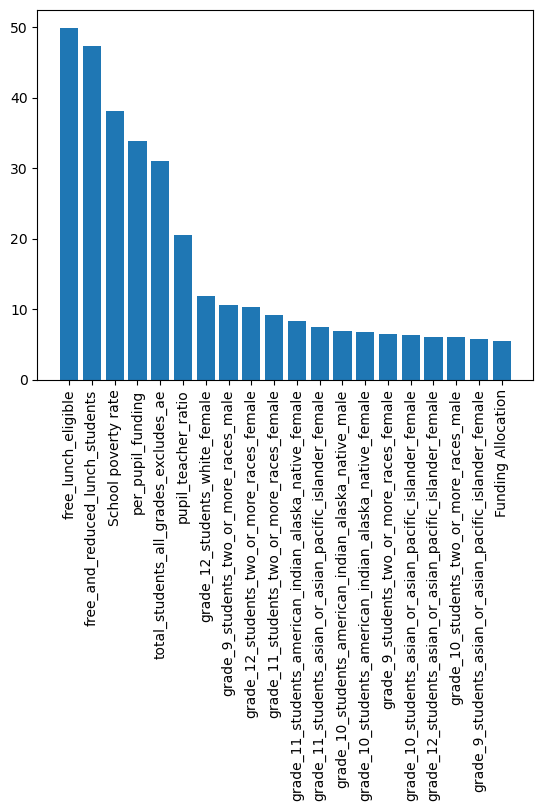

In [10]:
# explore the main continuous vals
cont_vals = X_train.loc[:, X_train.nunique() > 50]

cont_scores = cont_feat_selection(cont_vals,y_train)

# Plot scores
plt.bar(x=cont_scores['Feature'][:20],height=cont_scores['Score'][:20])
plt.xticks(rotation=90)
plt.show()

In [11]:
def cat_feature_selection(cat_data,y):
    ftest = SelectKBest(score_func = f_classif, k ='all')
    ftest.fit(cat_data,y)
    columns = pd.DataFrame(cat_data.columns)
    fscores = pd.DataFrame(ftest.scores_)
    ftest_df = pd.concat([columns, fscores], axis = 1)
    ftest_df.columns = ['Feature', 'Score']
    return ftest_df.sort_values(by = ['Score'], ascending = False)

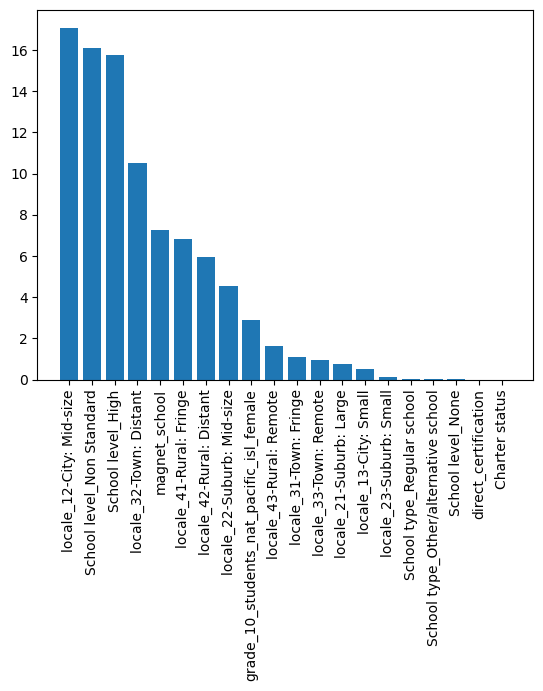

In [12]:
# explore the main categorical vals
cat_vals = X_train.loc[:, X_train.nunique() <= 10]

cat_scores = cont_feat_selection(cat_vals,y_train)

# Plot scores
plt.bar(x=cat_scores['Feature'][:20],height=cat_scores['Score'][:20])
plt.xticks(rotation=90)
plt.show()

Some slightly counterintuitive trends with funding ratios and graduation rate, but expected trends for the others

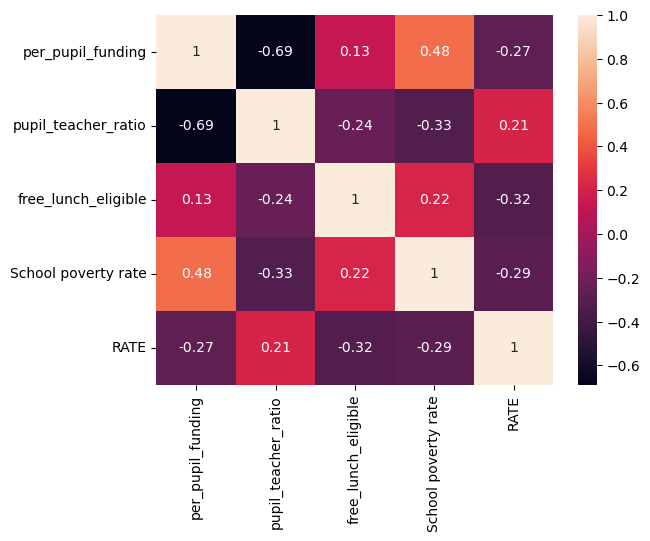

In [13]:
corr_df = pd.concat([X_train['per_pupil_funding'], X_train['pupil_teacher_ratio'],X_train['free_lunch_eligible'],X_train['School poverty rate'],y_train], axis = 1)
corr_matrix = corr_df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

## Modeling

There are two models here. The first one (right under) is basically a linear model but the outputs are scaled so that it can't output anything > 1 and < 0. The linear regression model is also there (technically can output graduation rates > 1 if the inputs are really out there), but it's also fine as well. Both have similar results, so both are used.

Potential areas for improvement may be in getting more data and potentially augmenting this with data from other states as well.

In [14]:
def generate_dense_model(X_train, y_train):
    # set seed for consistent results
    tf.random.set_seed(11)
    # model to force outputs between 0 and 1 (grad rate). basically just linear regression but outputs scaled
    # results will prob be about the same, but there's a guarantee that it can't output > 1 or < 0 values
    model = Sequential()
    model.add(Dense(1, input_dim=88, activation='sigmoid')) 
    model.compile(optimizer='adam', loss='mean_squared_error')  

    model.fit(X_train, y_train, epochs=400, batch_size=8, verbose=0)
    print("1 layer model outputs:")
    print(f"training error: {model.evaluate(X_train,y_train, verbose = 0)}")
    print(f"testing error: {model.evaluate(X_test,y_test, verbose = 0)}")

    y_train_pred = model.predict(X_train, verbose = 0)

    y_pred = model.predict(X_test, verbose = 0)

    print(f"training r2: {r2_score(y_train, y_train_pred)}")
    print(f"testing r2: {r2_score(y_test,y_pred)}")
    script_directory = os.getcwd()
    dense_filename = os.path.join(script_directory, 'dense_regression_model.h5')
    model.save(dense_filename)
    return model

In [15]:
model = generate_dense_model(X_train, y_train)

1 layer model outputs:
training error: 0.00795277301222086
testing error: 0.017779894173145294
training r2: 0.5338563775082061
testing r2: 0.17123164948050473


In [16]:
def generate_lr_model(X_train, y_train):
    reg = LinearRegression().fit(X_train, y_train)

    print(f"training mse: {mean_squared_error(y_train, reg.predict(X_train))}")
    print(f"testing mse: {mean_squared_error(y_test, reg.predict(X_test))}")

    print(f"training r2: {reg.score(X_train,y_train)}")
    print(f"testing r2: {reg.score(X_test,y_test)}")
    coefficients = reg.coef_

    print(f"linear regression coefficient corresponding to per pupil funding: {coefficients[0]}")
    # export model
    script_directory = os.getcwd()
    lr_filename = os.path.join(script_directory, 'linear_regression_model.pkl')
    joblib.dump(reg, lr_filename)
    return reg

In [17]:
reg = generate_lr_model(X_train, y_train)

training mse: 0.008208456602877574
testing mse: 0.01543402877907027
training r2: 0.518869739914153
testing r2: 0.2805787272988006
linear regression coefficient corresponding to per pupil funding: -0.07953381318685701


## Demo Functions

The how_much_more function can be demoed as having inputs equal to our set of columns. They can input a school, what they want the graduation rate to be, and what they might want to adjust, and it will output how much more of that feature will be necessary to reach that graduation %. This can be used to help policy makers best determine how much funds / where to use the funds / what features might be most relevant to them.

The optimization functions can also be used in the demo. If policymakers input a specified amount of funding, we can output a distribution of funds across the schools that maximizes the graduation rate under our model.

This can use the full 2020 data that we didn't use for training. This will act as how our model can be used on an "unseen" data source.

In [18]:
def how_much_more(school, wanted_grad_rate, col_name = "per_pupil_funding"):
    coefficients = list(reg.coef_)
    intercept = reg.intercept_
    t = df_to_model_format(school)[0]
    index_to_exclude = t.columns.get_loc(col_name)
    relevant_coefficients = coefficients[:index_to_exclude] + coefficients[index_to_exclude + 1:]
    inputs = list(np.array(t)[0])
    relevant_inputs = inputs[:index_to_exclude] + inputs[index_to_exclude + 1:]
    necessary_val = (wanted_grad_rate - np.dot(relevant_inputs, relevant_coefficients) - intercept)/coefficients[index_to_exclude]
    
    return inverse_scaling(necessary_val, index_to_exclude) - school[col_name]

In [19]:
df_2020 = get_main_data(["2020"])

print(f'{how_much_more(pd.DataFrame(df_2020.iloc[5,:]).T,.95, "pupil_teacher_ratio")} more pupil teacher ratio')

5    1.141476
Name: pupil_teacher_ratio, dtype: object more pupil teacher ratio


##### Optimization functions below (dense is for the first model, lr is for the linear regression model). The LR one has an additional penalty to enforce that the funding should be relatively equal as a parameter that can be tuned.

In [20]:
df_2020 = get_main_data(["2020"])

def objective_function_dense(params):
    out = 0
    X_modified = df_2020.copy()
    X_modified['per_pupil_funding'] = params / X_modified['COHORT']
    X_modified,_  = df_to_model_format(X_modified)
    
    out = out + np.dot(model.predict(X_modified,verbose = 0).flatten() , np.array(df_2020['COHORT']).reshape(-1,1)) / np.sum(df_2020['COHORT'])
    #negative here because scipy uses minimize
    return -1 * (out)

In [21]:
def perform_dense_optimization(max_funding = 50000000):
    initial_guess = df_2020['per_pupil_funding'] * df_2020['COHORT'] * max_funding / np.sum(df_2020['per_pupil_funding'] * df_2020['COHORT'])

    linear_constraint = LinearConstraint(np.ones_like(initial_guess), lb=max_funding, ub=max_funding)


    # Perform optimization
    result = minimize(
        objective_function_dense,
        initial_guess,
        constraints=[linear_constraint],
        method='SLSQP',  # You can choose different optimization methods
    )

    optimized_params = result.x


    funding_df_dense = pd.concat([df_2020['School name'].reset_index(drop = True), pd.DataFrame(optimized_params, columns = ['Funding']).reset_index(drop = True), pd.DataFrame(optimized_params/df_2020['COHORT']).reset_index(drop = True)],axis = 1)
    funding_df_dense = funding_df_dense.rename(columns = {"COHORT": "Per Pupil Funding"})

    print("ex. 5 schools from df")
    print(funding_df_dense.head())
    print("Objective Function Value:", -result.fun)
    return funding_df_dense

funding_df_dense = perform_dense_optimization()

ex. 5 schools from df
                School name        Funding  Per Pupil Funding
0  Church Point High School  260909.144254        2350.532831
1       Crowley High School  245151.383366        2228.648940
2       Midland High School  123117.419924        2931.367141
3     Elizabeth High School   79967.941757        2579.611024
4      Fairview High School   64088.495487        2786.456326
Objective Function Value: 0.861232269374294


In [ ]:
#higher values enforces that the funding is more equal
# make this really high and they will all be equal
penalty_weight = 110000
def objective_function_lr(params):
    out = 0
    X_modified = df_2020.copy()
    X_modified['per_pupil_funding'] = params / X_modified['COHORT']
    X_modified,_  = df_to_model_format(X_modified)
    mean = np.mean(X_modified['per_pupil_funding'])
    penalty = -1 * np.sum(np.power((X_modified['per_pupil_funding']-mean),2))/len(X_modified) * penalty_weight
    out = out + np.sum(reg.predict(X_modified).flatten())/len(X_modified) + penalty

    #negative here because scipy uses minimize
    return -1 * (out) 

def perform_lr_optimization(max_funding = 50000000):
    initial_guess = df_2020['per_pupil_funding'] * df_2020['COHORT'] * max_funding / np.sum(df_2020['per_pupil_funding'] * df_2020['COHORT'])
    bounds = [(0, max_funding)] * len(df_2020)
    linear_constraint = LinearConstraint(np.ones_like(initial_guess), lb=0, ub=max_funding)

    # Perform optimization
    result = minimize(
        objective_function_lr,
        initial_guess,
        constraints=[linear_constraint],
        bounds = bounds,
        method='SLSQP',  # You can choose different optimization methods
    )

    optimized_params = result.x

    funding_df_lr = pd.concat([df_2020['School name'].reset_index(drop = True), pd.DataFrame(optimized_params, columns = ['Funding']).reset_index(drop = True), pd.DataFrame(optimized_params/df_2020['COHORT']).reset_index(drop = True)],axis = 1)
    funding_df_lr = funding_df_lr.rename(columns = {"COHORT": "Per Pupil Funding"})

    print("ex. 5 schools from df")
    print(funding_df_lr.head())
    print("Objective Function Value:", -result.fun)
    return funding_df_lr

funding_df_lr = perform_lr_optimization()